# 1. Constant gaussian white noise (when we can talk about concentration)


$$
\frac{da}{dt} = P + \frac{\lambda_a \cdot a}{1 + k_a \cdot a} - \eta_a \cdot a - \mu_a \cdot a b
$$
$$
\frac{db}{dt} = N + \frac{\lambda_b \cdot b}{1 + k_b \cdot b} - \eta_b \cdot b - \mu_b \cdot a b
$$

Where:
- $a, b$: dynamic variables (e.g., population levels, concentrations)
- $P, N$: external input/production rates
- $\lambda_a, \lambda_b$: growth rate constants
- $k_a, k_b$: saturation constants (Hill-type terms)
- $\eta_a, \eta_b$: decay or dilution rates
- $\mu_a, \mu_b$: interaction strengths between $a$ and $b$

We firsty considers noise over N and P.

## 1.0 Frontiere equation


Considering $x(t)=a-b$, the concentration difference, one can recast the previous system into the following form 
$$\dot{x}=\dot{a}-{b}=[P-N]+\frac{\lambda_a a}{1+k_a a}-\frac{\lambda_b b}{1+k_b b} -\eta_a a+\eta_b b -(\mu_a-\mu_b)ab$$

As one want the fixed point equation for $(a^*,b^*)$ then $\dot{x}=0$. So as to recover the frontier, the previous equation must satisfy $a^*=b^*$. This yelds to the frontier equation i.e. {$(P,N)/a^*=b^*$ according to the fp equation}
$$P=N+(\frac{\lambda_b}{1+k_b a^*}-\frac{\lambda_a}{1+k_a a^*})a^*-(\eta_b-\eta_a)a^*+(\mu_a-\mu_b)a^{*2}$$

## 1.1 Symmetrical system

**ATTENTION** Pour rester dans le régime de bistabilité, une condition nécessaire (mais pas suffisante) est que $$P,N<1.25$$

By symmetrical, we mean that all constants $\lambda, \eta, \mu$ are equal for a and b. Therefore, the frontier equation is just 
$$P=N$$

We assume there exists intrinsic fluctuations on the entries
. As fluctuations are assumed to be independants btw each others wrt to time and space (white), and considering CLTn we choose a gaussian white noise, where the concentration value is drawn from $N=N_{grid}+\eta_N$. For now, the noise is time independant


Here the frontier equation is just $P=N$

### 1.1.1 Dynamics and plane classification

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm
from itertools import product

# --- Parameters ---
eta_a = 0.1
eta_b = 0.1
mu_a = 0.2
mu_b = 0.2
k_a = 0.7
k_b = 0.7
lambda_a = 1.0
lambda_b = 1.0

# --- Parameter grid for numerical integration ---
xlimit=1.3
ylimit=1.3
nb_of_points = 100
P_grid = np.linspace(0.0, ylimit, nb_of_points)  # P entre 0 et 1.25
N_grid = np.linspace(0.0, xlimit, nb_of_points)  # N entre 0 et 1.25

# Noise parameters
noise_sigma = 0.6  # écart-type du bruit gaussien ajouté

# Time span and initial condition for the ODE
t_span_full = (0, 150)
y0 = [1e-6, 1e-6]  # Conditions initiales pour a et b

# --- System equations ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# Integration helper function
def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]  # Valeurs finales de a et b

# --- Generate data with noise ---
results = []  # stockage des résultats (P bruité, N bruité, a, b)

for P, N in tqdm(product(P_grid, N_grid), total=nb_of_points*nb_of_points):
    noisy_P = max(0.0, P + np.random.normal(loc=0, scale=noise_sigma))  # P bruité, positif
    noisy_N = max(0.0, N + np.random.normal(loc=0, scale=noise_sigma))  # N bruité, positif
    
    a_final, b_final = integrate_ode(noisy_P, noisy_N, y0, t_span_full)
    
    # Clamp les valeurs pour la visualisation
    results.append((noisy_P, noisy_N, np.clip(a_final, 0, 10), np.clip(b_final, 0, 10)))

results = np.array(results)
P_plot = results[:, 0]
N_plot = results[:, 1]
a_low_plot = results[:, 2]
b_low_plot = results[:, 3]



  0%|          | 0/10000 [00:00<?, ?it/s]

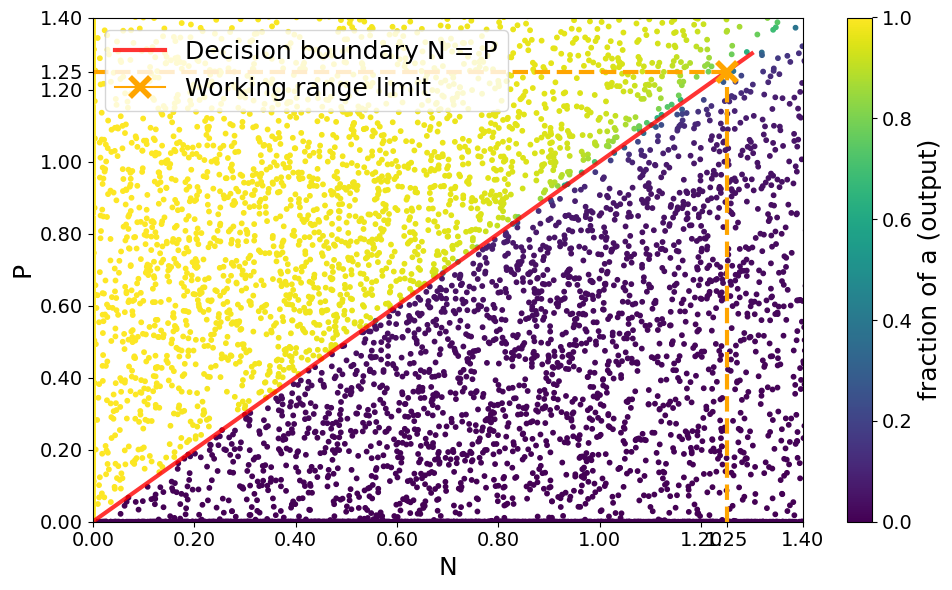

In [17]:
# --- Plot the phase diagram ---
fig, ax = plt.subplots(figsize=(10, 6))

a_percentage = a_low_plot / (a_low_plot + b_low_plot + 1e-10)

sc = ax.scatter(N_plot, P_plot, c=a_percentage, cmap='viridis', s=10, marker='o')
ax.set_xlabel("N", fontsize=18)
ax.set_ylabel("P", fontsize=18)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("fraction of a (output)", fontsize=18)
cbar.ax.tick_params(labelsize=14)


# Tracé de la diagonale N = P
ax.plot([0, xlimit], [0, ylimit], color='red', alpha=0.8, label='Decision boundary N = P', linewidth=3)

# Tracé des traits pointillés partant de (1.25,1.25) jusqu'aux axes
x_cross, y_cross = 1.25, 1.25
ax.plot([x_cross, x_cross], [0, y_cross], color='orange', linestyle='--', linewidth=3)
ax.plot([0, x_cross], [y_cross, y_cross], color='orange', linestyle='--', linewidth=3)
ax.plot(x_cross, y_cross, marker='x', color='orange', markersize=15, mew=4, label='Working range limit')

# Limiter les axes entre 0 et 3
ax.set_xlim(0, xlimit)
ax.set_ylim(0, ylimit)

# Ajouter la graduation 1.25 sur les axes
xticks = list(ax.get_xticks()) + [1.25]
yticks = list(ax.get_yticks()) + [1.25]
ax.set_xticks(sorted(set(xticks)))
ax.set_yticks(sorted(set(yticks)))

# Augmenter la taille des ticks
ax.tick_params(axis='both', which='major', labelsize=14)

# Légende en haut à gauche
ax.legend(fontsize=18, loc='upper left')

plt.tight_layout()
plt.show()





There is an important point to consider : a condition for the bistability is that $P,N<1.25$. We can indeed see that approaching P=N=1.25, there are more and more 50/50 final state, creation a cone oriented toward the upper right which contain more and more non decided neurons.

Up to now, we've used a fully symmetrical version of the system, whose parameters are symetrical 
$$ \begin{aligned} \eta_a = \eta_b &= 0.1 \\ \mu_a =\mu_b &= 0.2 \\ k_a = k_b &= 0.7 \\ \lambda_a = \lambda_b &= 1.0 \end{aligned} $$
There is always a WTA, even for close initial P and N values, yet the more P and N are initially close, the more it takes time to reach the 0-100 final concentration.
For P=N, this amount ouf time is infinite and both species end up at the same concetration 50/50 of a and b (first graph)
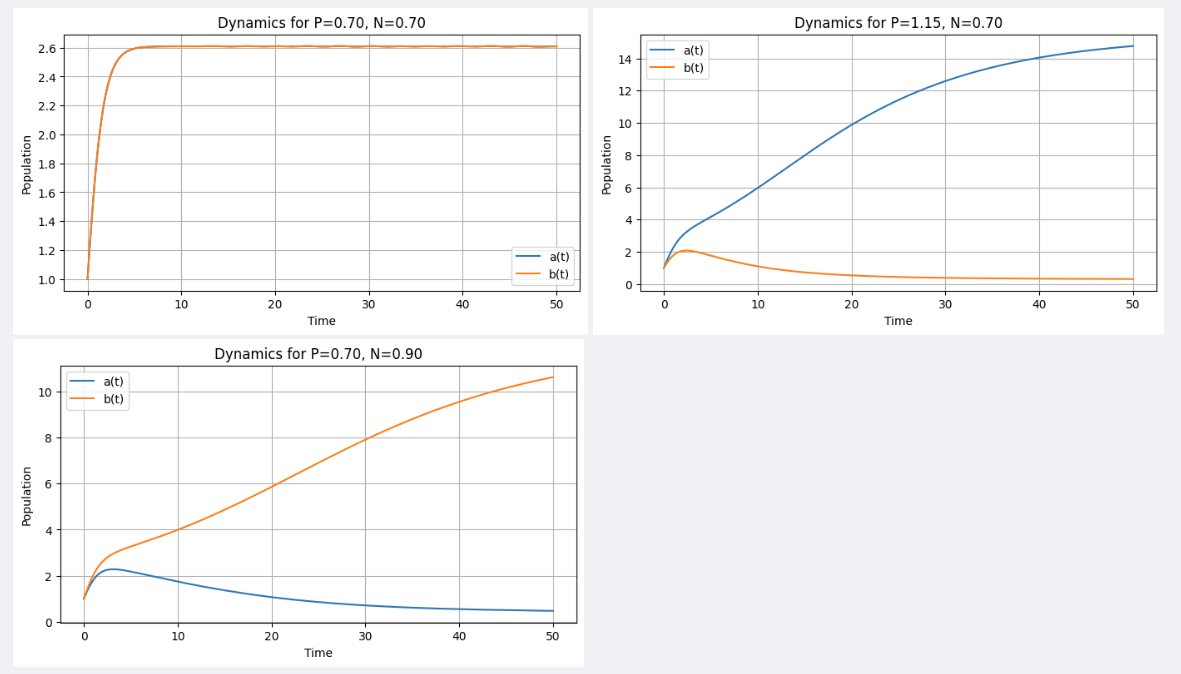

This is no surprise : the higher is the difference between N and P (ie the further away we are from the diagonal N=P), the fastest it takes for one species to win over the other. For N=P, this time is infinite. 

We should can expect a power law for the time to converge depending on the initial concentration P and N, ie the position in the configurational space  $$t_f\propto|P-N|^{-\alpha}$$

Le but est de calculer le **temps caractéristique** qu’il faut à un neurone pour atteindre un **état décidé**, défini comme :

1. **Stationnarité** :  
   Les dérivées de \(a(t)\) et \(b(t)\) restent faibles pendant un certain nombre de points consécutifs.  
   on impose
   $$
   \Bigl|\dot a(t)\Bigr| < \varepsilon_{\rm stat}
   \quad\text{et}\quad
   \Bigl|\dot b(t)\Bigr| < \varepsilon_{\rm stat}
   $$
   pendant \(M\) pas de temps d’affilée.

2. **Dissymétrie** :  
   Les concentrations finales de \(a\) et \(b\) ne sont pas égales, c’est-à-dire
   $$
   \bigl|\,a(t) - b(t)\bigr| > \varepsilon_{\rm diff}
   $$
   sur la même fenêtre de \(M\) pas.

ATTENTION BALATAGE AUTOURS DE P+N+ !!

Calcul des temps de décision en fonction de P - N...


100%|██████████| 500/500 [00:51<00:00,  9.78it/s]


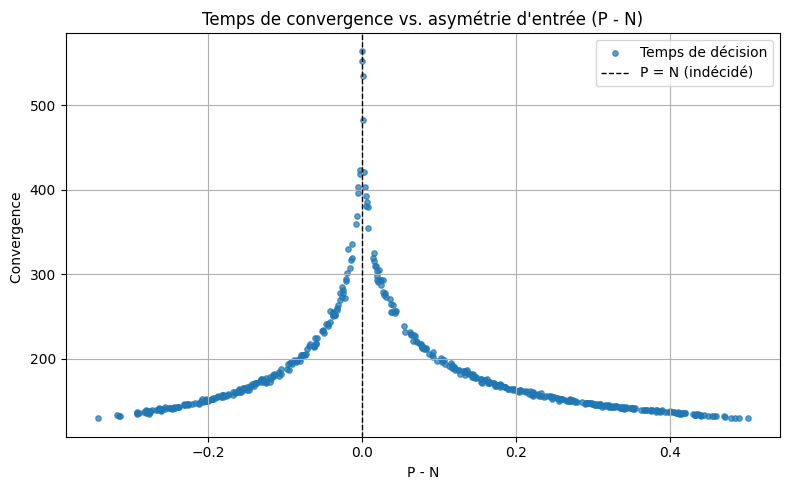

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# --- Paramètres dynamiques ---
eta_a, eta_b = 0.1, 0.1
mu_a, mu_b = 0.2, 0.2
k_a, k_b = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

# --- ODEs ---
def da_dt(a, b, P):
    return P + (lambda_a * a)/(1 + k_a*a) - eta_a*a - mu_a*a*b

def db_dt(a, b, N):
    return N + (lambda_b * b)/(1 + k_b*b) - eta_b*b - mu_b*a*b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Paramètres de simulation ---
tf = 1000
t_eval = np.linspace(0, tf, 3000)
dt = t_eval[1] - t_eval[0]

P_range = np.linspace(0.5, 1.25, 500)
N_fixed = 0.8 # N est fixé, on fait varier P autour

noise_sigma = 0.02  # bruit sur les inputs

# --- Seuils de décision ---
tol_stationary = 1e-4     # seuil de variation |da/dt| et |db/dt|
tol_difference = 1e-2     # seuil d'asymétrie entre a et b
M = 10                    # M points consécutifs stables

# --- Stockage ---
delta_PN_list = []
decision_times = []

print("Calcul des temps de décision en fonction de P - N...")
for P in tqdm(P_range):
    # Bruit sur P et N
    P_noisy = max(P + np.random.normal(scale=noise_sigma), 0)
    N_noisy = max(N_fixed + np.random.normal(scale=noise_sigma), 0)
    delta_PN = P_noisy - N_noisy

    # Simulation dynamique
    sol = solve_ivp(system, (0, tf), [1e-6, 1e-6],
                    args=(P_noisy, N_noisy),
                    t_eval=t_eval, method="RK45", rtol=1e-8, atol=1e-10)

    a, b = sol.y
    t = sol.t

    # Dérivées numériques
    da = np.diff(a) / dt
    db = np.diff(b) / dt
    diff_ab = np.abs(a - b)

    # Recherche d'un état décidé stationnaire
    t_decided = np.inf
    for i in range(len(da) - M):
        if (np.all(np.abs(da[i:i+M]) < tol_stationary) and
            np.all(np.abs(db[i:i+M]) < tol_stationary) and
            np.all(diff_ab[i:i+M] > tol_difference)):
            t_decided = t[i]
            break

    delta_PN_list.append(delta_PN)
    decision_times.append(t_decided)

# --- Conversion ---
delta_PN_arr = np.array(delta_PN_list)
decision_times_arr = np.array(decision_times)

# --- Affichage ---
plt.figure(figsize=(8, 5))
mask = np.isfinite(decision_times_arr)
plt.scatter(delta_PN_arr[mask], decision_times_arr[mask], s=15, alpha=0.7, label="Temps de décision")
plt.axvline(0, color='k', linestyle='--', lw=1, label="P = N (indécidé)")
plt.xlabel("P - N")
plt.ylabel("Convergence ")
plt.title("Temps de convergence vs. asymétrie d'entrée (P - N)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# --- Paramètres dynamiques ---
eta_a, eta_b = 0.1, 0.1
mu_a, mu_b = 0.2, 0.2
k_a, k_b = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

# --- ODEs ---
def da_dt(a, b, P):
    return P + (lambda_a * a)/(1 + k_a*a) - eta_a*a - mu_a*a*b

def db_dt(a, b, N):
    return N + (lambda_b * b)/(1 + k_b*b) - eta_b*b - mu_b*a*b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Paramètres de simulation ---
tf = 1000
t_eval = np.linspace(0, tf, 3000)
dt = t_eval[1] - t_eval[0]

# --- Balayage gaussien autour de P = N ---
P_center, N_center = 1.0,1.0
num_samples = 100
delta_range = np.random.normal(loc=0.0, scale=0.1, size=num_samples)
noise_sigma = 0.02

# --- Seuils de décision ---
tol_stationary = 1e-4
tol_difference = 1e-2
M = 10

# --- Stockage ---
delta_PN_list = []
decision_times = []

# --- Simulation ---
for delta in tqdm(delta_range, desc="Simulation"):
    P = P_center + delta / 2
    N = N_center - delta / 2
    P_noisy = max(P + np.random.normal(scale=noise_sigma), 0)
    N_noisy = max(N + np.random.normal(scale=noise_sigma), 0)
    delta_PN = P_noisy - N_noisy

    sol = solve_ivp(system, (0, tf), [1e-6, 1e-6],
                    args=(P_noisy, N_noisy),
                    t_eval=t_eval, method="RK45", rtol=1e-8, atol=1e-10)
    a, b = sol.y
    t = sol.t

    da = np.diff(a) / dt
    db = np.diff(b) / dt
    diff_ab = np.abs(a - b)

    t_decided = np.inf
    for i in range(len(da) - M):
        if (np.all(np.abs(da[i:i+M]) < tol_stationary) and
            np.all(np.abs(db[i:i+M]) < tol_stationary) and
            np.all(diff_ab[i:i+M] > tol_difference)):
            t_decided = t[i]
            break

    delta_PN_list.append(delta_PN)
    decision_times.append(t_decided)

# --- Analyse ---
delta_PN_arr = np.array(delta_PN_list)
decision_times_arr = np.array(decision_times)
mask = np.isfinite(decision_times_arr)
dPN = delta_PN_arr[mask]
tconv = decision_times_arr[mask]

# Séparation selon le signe
dPN_pos = dPN[dPN > 0]
t_pos = tconv[dPN > 0]
dPN_neg = -dPN[dPN < 0]  # on prend -delta pour le fit
t_neg = tconv[dPN < 0]

# --- Fit log-log ---
eps = 1e-4
mask_pos = dPN_pos > eps
mask_neg = dPN_neg > eps

log_dPN_pos = np.log(dPN_pos[mask_pos])
log_t_pos = np.log(t_pos[mask_pos])
slope_pos, intercept_pos = np.polyfit(log_dPN_pos, log_t_pos, 1)
k_pos = -slope_pos
C_pos = np.exp(intercept_pos)

log_dPN_neg = np.log(dPN_neg[mask_neg])
log_t_neg = np.log(t_neg[mask_neg])
slope_neg, intercept_neg = np.polyfit(log_dPN_neg, log_t_neg, 1)
k_neg = -slope_neg
C_neg = np.exp(intercept_neg)



Simulation: 100%|██████████| 100/100 [00:09<00:00, 10.87it/s]


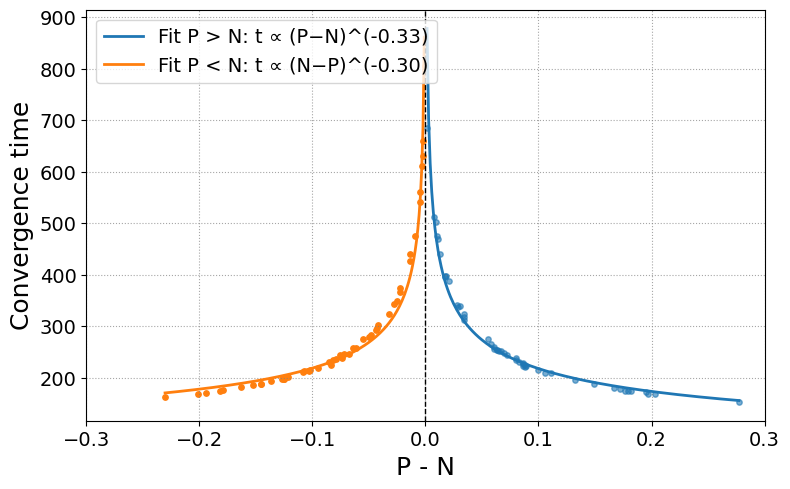

In [3]:
# Définir l’intervalle symétrique autour de zéro (exemple L=0.5, adapte selon ton besoin)
L = 0.3

# --- Filtrer les données pour ne garder que celles dans [-L, L] ---
mask_pos_interval = (dPN_pos <= L) & (dPN_pos >= 0)
mask_neg_interval = (dPN_neg <= L) & (dPN_neg >= 0)

dPN_pos_filtered = dPN_pos[mask_pos_interval]
t_pos_filtered = t_pos[mask_pos_interval]

dPN_neg_filtered = dPN_neg[mask_neg_interval]
t_neg_filtered = t_neg[mask_neg_interval]

# --- Tracé final en linéaire linéaire ---
fig, ax = plt.subplots(figsize=(8, 5))

# Scatter filtré (avec labels si tu veux légende)
ax.scatter(dPN_pos_filtered, t_pos_filtered, color='C0', s=15, alpha=0.6)
ax.scatter(-dPN_neg_filtered, t_neg_filtered, color='C1', s=15)

# Domaines de fit dans l’intervalle défini
dPNp_model = np.linspace(max(dPN_pos_filtered.min(), 0.001), dPN_pos_filtered.max(), 200)
tpos_model = C_pos * dPNp_model**(-k_pos)

dPNn_model = np.linspace(max(dPN_neg_filtered.min(), 0.001), dPN_neg_filtered.max(), 200)
tneg_model = C_neg * dPNn_model**(-k_neg)

# Courbes de fit
ax.plot(dPNp_model, tpos_model, color='C0', lw=2,
         label=f'Fit P > N: t ∝ (P−N)^(-{k_pos:.2f})')
ax.plot(-dPNn_model, tneg_model, color='C1', lw=2,
         label=f'Fit P < N: t ∝ (N−P)^(-{k_neg:.2f})')

# Ligne verticale P=N
ax.axvline(0, color='k', ls='--', lw=1)

# Limites de l’axe x symétriques
ax.set_xlim(-L, L)

# Textes agrandis
ax.set_xlabel("P - N", fontsize=18)
ax.set_ylabel("Convergence time", fontsize=18)

# Agrandir ticks
ax.tick_params(axis='both', which='major', labelsize=14)

# Agrandir légende
ax.legend(fontsize=14, loc='upper left')

ax.grid(True, ls=':', color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

In [7]:
# Liste des valeurs centrales de P=N à explorer
P_vals = np.linspace(0, 1.25, 30)  # adapte la plage et le nombre
alphas_pos = []
alphas_neg = []

for P_center in tqdm(P_vals, desc="Exploration P=N"):

    delta_range = np.random.normal(loc=0.0, scale=0.1, size=num_samples)

    delta_PN_list = []
    decision_times = []

    for delta in delta_range:
        P = P_center + delta / 2
        N = P_center - delta / 2
        P_noisy = max(P + np.random.normal(scale=noise_sigma), 0)
        N_noisy = max(N + np.random.normal(scale=noise_sigma), 0)
        delta_PN = P_noisy - N_noisy

        sol = solve_ivp(system, (0, tf), [1e-6, 1e-6],
                        args=(P_noisy, N_noisy),
                        t_eval=t_eval, method="RK45", rtol=1e-8, atol=1e-10)
        a, b = sol.y
        t = sol.t

        da = np.diff(a) / dt
        db = np.diff(b) / dt
        diff_ab = np.abs(a - b)

        t_decided = np.inf
        for i in range(len(da) - M):
            if (np.all(np.abs(da[i:i+M]) < tol_stationary) and
                np.all(np.abs(db[i:i+M]) < tol_stationary) and
                np.all(diff_ab[i:i+M] > tol_difference)):
                t_decided = t[i]
                break

        delta_PN_list.append(delta_PN)
        decision_times.append(t_decided)

    # Analyse pour cette valeur de P_center
    delta_PN_arr = np.array(delta_PN_list)
    decision_times_arr = np.array(decision_times)
    mask = np.isfinite(decision_times_arr)
    dPN = delta_PN_arr[mask]
    tconv = decision_times_arr[mask]

    dPN_pos = dPN[dPN > 0]
    t_pos = tconv[dPN > 0]
    dPN_neg = -dPN[dPN < 0]
    t_neg = tconv[dPN < 0]

    # Fit log-log
    eps = 1e-4
    mask_pos = dPN_pos > eps
    mask_neg = dPN_neg > eps

    if np.sum(mask_pos) >= 5:
        log_dPN_pos = np.log(dPN_pos[mask_pos])
        log_t_pos = np.log(t_pos[mask_pos])
        slope_pos, _ = np.polyfit(log_dPN_pos, log_t_pos, 1)
        alphas_pos.append(-slope_pos)
    else:
        alphas_pos.append(np.nan)

    if np.sum(mask_neg) >= 5:
        log_dPN_neg = np.log(dPN_neg[mask_neg])
        log_t_neg = np.log(t_neg[mask_neg])
        slope_neg, _ = np.polyfit(log_dPN_neg, log_t_neg, 1)
        alphas_neg.append(-slope_neg)
    else:
        alphas_neg.append(np.nan)


Exploration P=N: 100%|██████████| 30/30 [04:25<00:00,  8.86s/it]


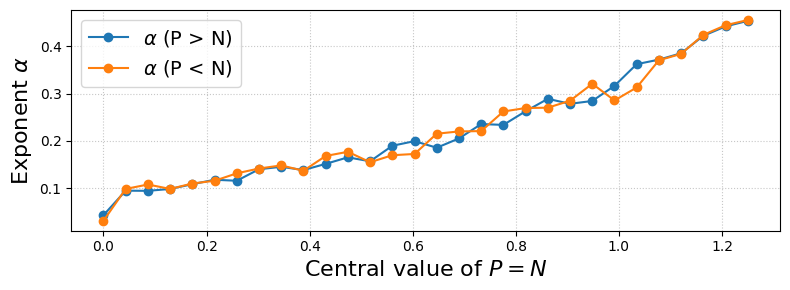

In [9]:
plt.figure(figsize=(8,3))
plt.plot(P_vals, alphas_pos, 'o-', label=r'$\alpha$ (P > N)', color='C0')
plt.plot(P_vals, alphas_neg, 'o-', label=r'$\alpha$ (P < N)', color='C1')



plt.xlabel(r'Central value of $P=N$', fontsize=16)
plt.ylabel(r'Exponent $\alpha$', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, ls=':', alpha=0.7)
plt.tight_layout()
plt.show()


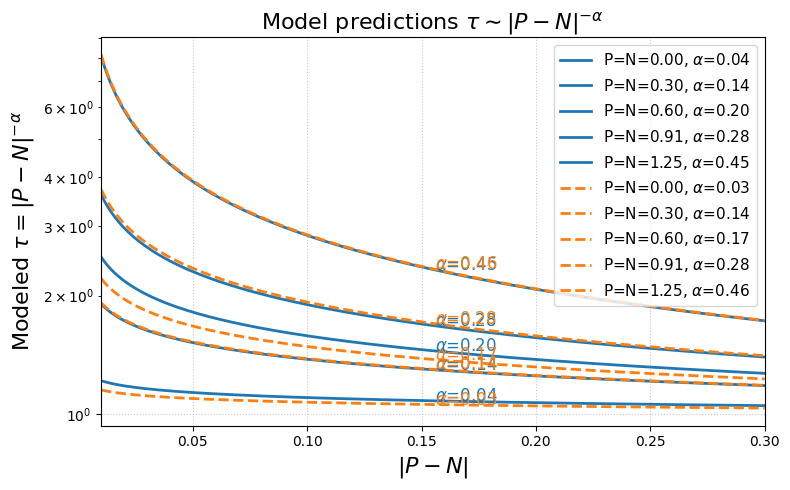

In [11]:
import matplotlib.pyplot as plt

# Définir les indices des valeurs de P=N que tu veux afficher
# Par exemple, on prend 5 courbes régulièrement espacées
idx_to_plot = np.linspace(0, len(P_vals) - 1, 5, dtype=int)

PN_deltas = np.linspace(0.01, 0.3, 200)  # Évite le 0 pour éviter log(0)

plt.figure(figsize=(8,5))

# --- P > N ---
for i in idx_to_plot:
    alpha = alphas_pos[i]
    if not np.isnan(alpha):
        tau = PN_deltas**(-alpha)
        plt.plot(PN_deltas, tau, color='C0', lw=2, label=fr'P=N={P_vals[i]:.2f}, $\alpha$={alpha:.2f}')
        # Annoter la courbe à une position fixe (ex: au milieu)
        plt.text(PN_deltas[100], tau[100], fr'$\alpha$={alpha:.2f}', color='C0', fontsize=12)

# --- P < N ---
for i in idx_to_plot:
    alpha = alphas_neg[i]
    if not np.isnan(alpha):
        tau = PN_deltas**(-alpha)
        plt.plot(PN_deltas, tau, color='C1', lw=2, linestyle='--', label=fr'P=N={P_vals[i]:.2f}, $\alpha$={alpha:.2f}')
        plt.text(PN_deltas[100], tau[100], fr'$\alpha$={alpha:.2f}', color='C1', fontsize=12)

# Mise en forme
plt.xlabel(r'$|P - N|$', fontsize=16)
plt.ylabel(r'Modeled $\tau = |P-N|^{-\alpha}$', fontsize=16)
plt.xlim(0.01, 0.3)
plt.yscale("log")
plt.grid(True, ls=':', alpha=0.7)
plt.title(r'Model predictions $\tau \sim |P-N|^{-\alpha}$', fontsize=16)
plt.legend(fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# --- Paramètres dynamiques ---
eta_a, eta_b = 0.1, 0.1
mu_a, mu_b = 0.2, 0.2
k_a, k_b = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

# --- ODEs ---
def da_dt(a, b, P):
    return P + (lambda_a * a)/(1 + k_a*a) - eta_a*a - mu_a*a*b

def db_dt(a, b, N):
    return N + (lambda_b * b)/(1 + k_b*b) - eta_b*b - mu_b*a*b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Paramètres de simulation ---
tf = 1000
t_eval = np.linspace(0, tf, 3000)
dt = t_eval[1] - t_eval[0]

# --- Balayage gaussien autour de P = N ---
P_center, N_center = 1.0, 1.0
num_samples = 500
delta_range = np.random.normal(loc=0.0, scale=0.1, size=num_samples)

noise_sigma = 0.02  # bruit sur les inputs

# --- Seuils de décision ---
tol_stationary = 1e-4
tol_difference = 1e-2
M = 10

# --- Stockage ---
delta_PN_list = []
decision_times = []

print("Calcul des temps de décision en fonction de P - N...")
for delta in tqdm(delta_range):
    # Définir P et N autour de P_center = N_center
    P = P_center + delta / 2
    N = N_center - delta / 2

    # Ajouter du bruit
    P_noisy = max(P + np.random.normal(scale=noise_sigma), 0)
    N_noisy = max(N + np.random.normal(scale=noise_sigma), 0)
    delta_PN = P_noisy - N_noisy

    # Simulation dynamique
    sol = solve_ivp(system, (0, tf), [1e-6, 1e-6],
                    args=(P_noisy, N_noisy),
                    t_eval=t_eval, method="RK45", rtol=1e-8, atol=1e-10)

    a, b = sol.y
    t = sol.t

    # Dérivées numériques
    da = np.diff(a) / dt
    db = np.diff(b) / dt
    diff_ab = np.abs(a - b)

    # Recherche d'un état décidé stationnaire
    t_decided = np.inf
    for i in range(len(da) - M):
        if (np.all(np.abs(da[i:i+M]) < tol_stationary) and
            np.all(np.abs(db[i:i+M]) < tol_stationary) and
            np.all(diff_ab[i:i+M] > tol_difference)):
            t_decided = t[i]
            break

    delta_PN_list.append(delta_PN)
    decision_times.append(t_decided)

# --- Conversion ---
delta_PN_arr = np.array(delta_PN_list)
decision_times_arr = np.array(decision_times)

# --- Affichage brut ---
plt.figure(figsize=(8, 5))
mask = np.isfinite(decision_times_arr)
plt.scatter(delta_PN_arr[mask], decision_times_arr[mask], s=15, alpha=0.7, label="Decision time")
plt.axvline(0, color='k', linestyle='--', lw=1, label="P = N (undicided)")
plt.xlabel("P - N")
plt.ylabel("Convergence time toward a decided state")
plt.title("Convergence time vs. input asymmetry (P - N)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Calcul des temps de décision en fonction de P - N...


 74%|███████▍  | 369/500 [00:20<00:07, 18.23it/s]


KeyboardInterrupt: 

Il existe une asymétrie en P>N (droite) et P<N (gauche). En effet, la quantité clée est le pourcentage de a et tous les neurones partant de a,b=0, pour P<N (dans le cas full symétrique), alors il est très rapide de converger vers l'état "off" puisqu'on en part. 

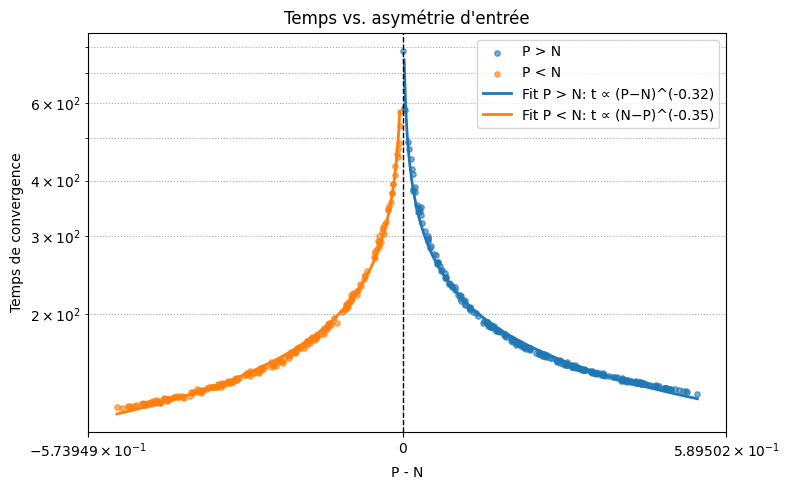

In [44]:
# --- Filtrage pour éviter les valeurs trop petites ---
eps = 1e-3
mask_pos = dPN_pos > eps
mask_neg = dPN_neg > eps

# --- Fit log-log pour P > N ---
log_dPN_pos = np.log(dPN_pos[mask_pos])
log_t_pos = np.log(t_pos[mask_pos])
slope_pos, intercept_pos = np.polyfit(log_dPN_pos, log_t_pos, 1)
k_pos = -slope_pos
C_pos = np.exp(intercept_pos)

# --- Fit log-log pour P < N ---
log_dPN_neg = np.log(dPN_neg[mask_neg])
log_t_neg = np.log(t_neg[mask_neg])
slope_neg, intercept_neg = np.polyfit(log_dPN_neg, log_t_neg, 1)
k_neg = -slope_neg
C_neg = np.exp(intercept_neg)
fig, ax = plt.subplots(figsize=(8, 5))

# Points
ax.scatter(dPN_pos, t_pos, color='C0', s=15, alpha=0.6, label='P > N')
ax.scatter(-dPN_neg, t_neg, color='C1', s=15, alpha=0.6, label='P < N')

# Modèles
dPNp_model = np.linspace(dPN_pos[mask_pos].min(), dPN_pos[mask_pos].max(), 200)
tpos_model = C_pos * dPNp_model**(-k_pos)
dPNn_model = np.linspace(dPN_neg[mask_neg].min(), dPN_neg[mask_neg].max(), 200)
tneg_model = C_neg * dPNn_model**(-k_neg)

# Courbes
ax.plot(dPNp_model, tpos_model, color='C0', lw=2,
         label=f'Fit P > N: t ∝ (P−N)^(-{k_pos:.2f})')
ax.plot(-dPNn_model, tneg_model, color='C1', lw=2,
         label=f'Fit P < N: t ∝ (N−P)^(-{k_neg:.2f})')

# Axe & style
ax.axvline(0, color='k', ls='--', lw=1)
ax.set_xlabel("P - N")
ax.set_ylabel("Temps de convergence")
ax.set_title("Temps vs. asymétrie d'entrée")
ax.set_xscale('symlog')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', axis='both', ls=':', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()


In [1]:
# ...

fig, ax = plt.subplots(figsize=(8,5))

# Points
ax.scatter( dPN_pos, t_pos, color='C0', s=15, alpha=0.6, label='P>N')
ax.scatter(-dPN_neg, t_neg, color='C1', s=15, alpha=0.6, label='P<N')

# Domaines continus pour tracer les courbes
dPNp_model = np.linspace(dPN_pos.min(), dPN_pos.max(), 200)
tpos_model = C_pos * dPNp_model**(-k_pos)
dPNn_model = np.linspace(dPN_neg.min(), dPN_neg.max(), 200)
tneg_model = C_neg * dPNn_model**(-k_neg)

# Courbes
ax.plot( dPNp_model, tpos_model, color='C0', lw=2,
         label=f'Fit P>N: t∝(P-N)^(-0.33)')
ax.plot(-dPNn_model, tneg_model, color='C1', lw=2,
         label=f'Fit P<N: t∝(N-P)^(-0.33)')

ax.axvline(0, color='k', ls='--', lw=1)

ax.set_xlabel("P - N")
ax.set_ylabel("Convergence time (log scale)")
ax.set_title("Convergence time toward a decided state vs. asymmetry (P - N)")

ax.set_xscale('symlog')
ax.set_yscale('log')
ax.legend()

# Ajout explicite de la grille sur les axes x et y, pour les major et minor ticks
ax.grid(True, which='both', axis='both', ls=':', color='gray', alpha=0.7)

plt.tight_layout()
plt.show()




NameError: name 'plt' is not defined

We obtain the caracteristic time to converge toward a decided state (on or off), as a power law of P-N :
$$t_f\propto|P-N|^{-0.32} \text{ for P>N}$$
$$t_f\propto|P-N|^{-0.34} \text{ for P<N}$$

### 1.1.2 Density profile analysis of the frontier, wrt the computation time

**(a) Without noise**

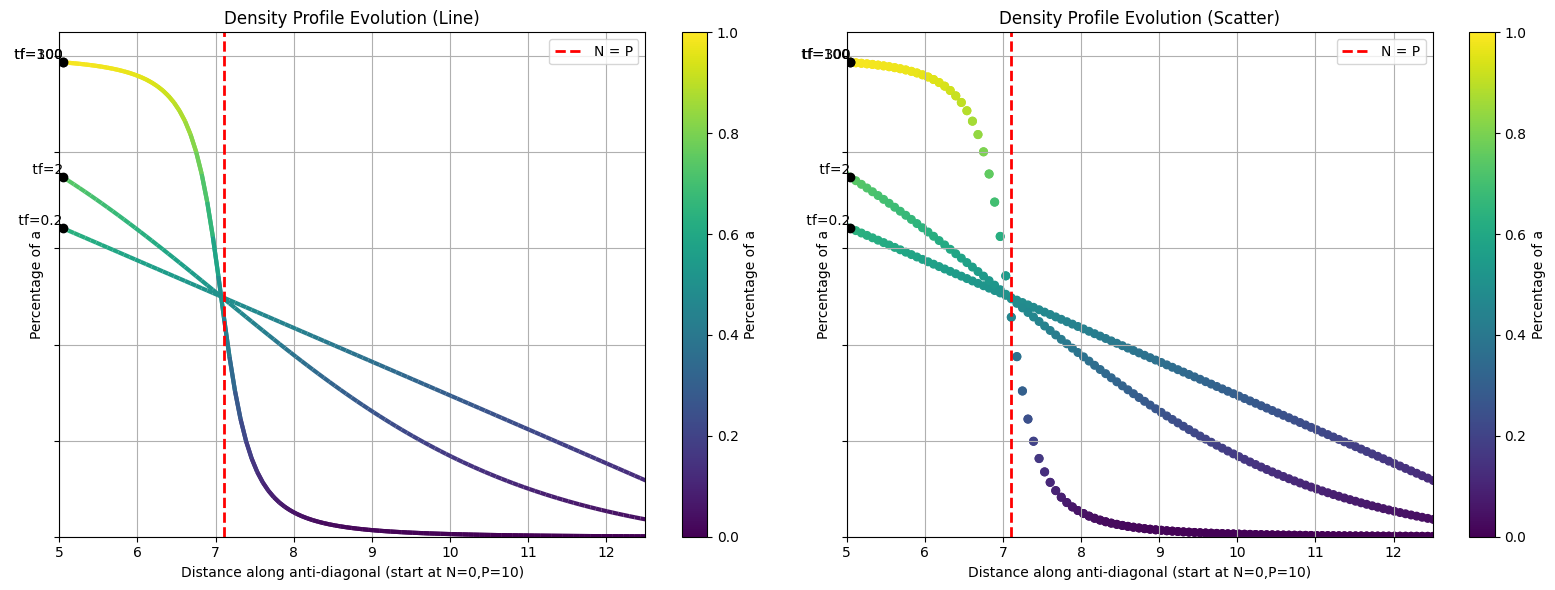

Smooth curves, no false nor true positive, the more you wait, the less ambivalent the classification is (ie the more decided the final system is).
There for convergence time >300, the computer makes no error.


**(b) With noise**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.collections import LineCollection
from tqdm import tqdm

# --- System parameters ---
eta_a, eta_b = 0.1, 0.1
mu_a, mu_b   = 0.2, 0.2
k_a, k_b     = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

num_points = 200

# --- Noise & integration setup ---
noise_sigma = 0.1
y0 = [1e-6, 1e-6]

# --- Final times to compare transient vs steady ---
tf_list = [300,1000]

# Set desired plot ranges here:
x_min, x_max = 5, 12.5
y_min_plot, y_max_plot = 0, 1.05


In [7]:
# --- ODE system ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0, args=(P, N),
                    t_eval=t_eval, method='RK45',
                    rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]

# --- Parameterize anti-diagonal from (N=0, P=10) to (N=10, P=0) ---

t_line = np.linspace(0, 1, num_points)
N_diag = 10 * t_line
P_diag = 10 * (1 - t_line)
distance_diag = 10 * np.sqrt(2) * t_line



# --- Compute percentage-of-a profiles ---
profiles = {}
for tf in tqdm(tf_list, desc="Processing tf values"):
    profile = np.zeros(num_points)
    for i in range(num_points):
        noisy_N = max(0, N_diag[i] + np.random.normal(scale=noise_sigma))
        noisy_P = max(0, P_diag[i] + np.random.normal(scale=noise_sigma))
        a_f, b_f = integrate_ode(noisy_P, noisy_N, y0, (0, tf))
        profile[i] = np.clip(a_f / (a_f + b_f + 1e-10), 0, 1)
    profiles[tf] = profile

# --- Prepare colormap ---
all_vals = np.concatenate(list(profiles.values()))
norm = plt.Normalize(vmin=all_vals.min(), vmax=all_vals.max())
cmap = plt.cm.viridis

# --- Compute where N = P on the anti-diagonal ---
idx_eq = np.argmin(np.abs(N_diag - P_diag))
distance_eq = distance_diag[idx_eq]



Processing tf values: 100%|██████████| 2/2 [01:06<00:00, 33.28s/it]


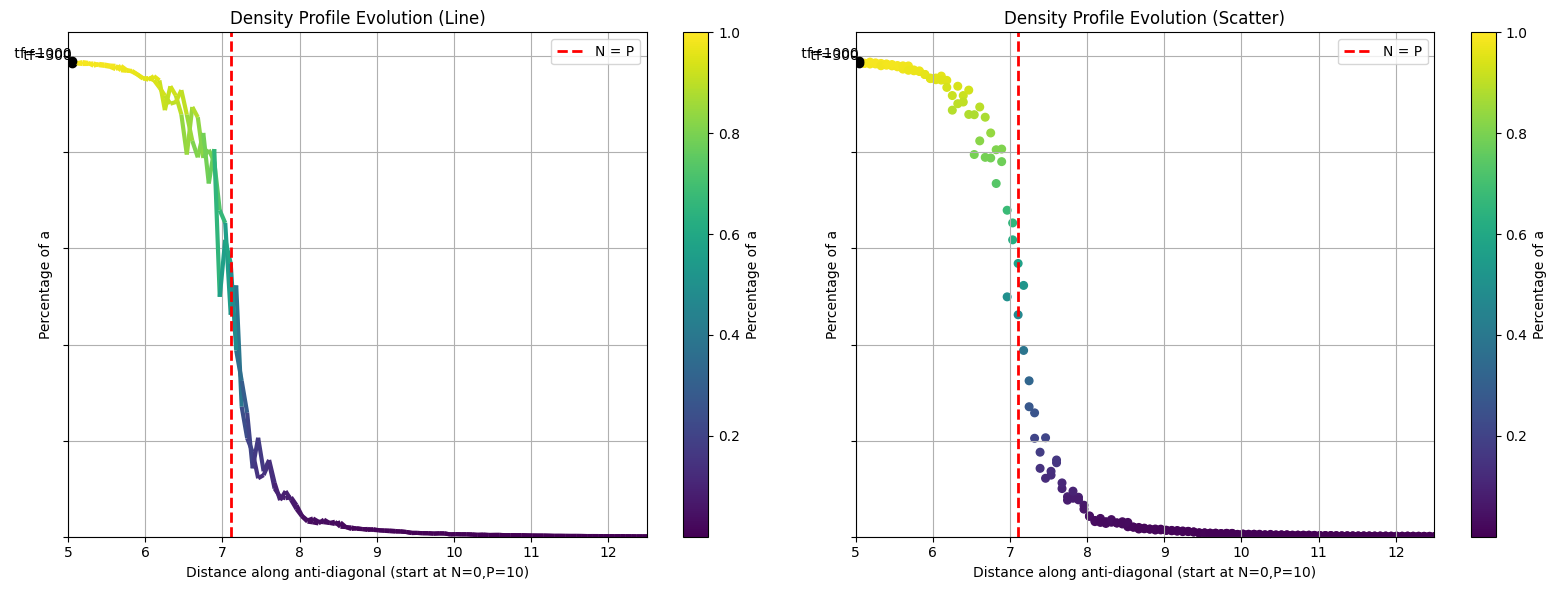

In [8]:
# --- Plotting ---

# Find an index for annotation in the visible window
annotate_index = np.where((distance_diag >= x_min) & (distance_diag <= x_max))[0][0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Line plot with colored segments
for tf, profile in profiles.items():
    points   = np.vstack([distance_diag, profile]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    seg_colors = [(cmap(norm((profile[i] + profile[i+1]) / 2))) for i in range(len(profile)-1)]
    lc = LineCollection(segments, colors=seg_colors, linewidths=3)
    ax1.add_collection(lc)
    # annotate at the first visible point
    d0 = distance_diag[annotate_index]
    p0 = profile[annotate_index]
    ax1.plot(d0, p0, 'ko')
    ax1.text(d0, p0, f' tf={tf}', va='bottom', ha='right')

# Add the N = P frontier line
ax1.axvline(distance_eq, color='red', linestyle='--', linewidth=2, label='N = P')

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min_plot, y_max_plot)
ax1.set_xlabel("Distance along anti-diagonal (start at N=0,P=10)")
ax1.set_ylabel("Percentage of a")
ax1.set_title("Density Profile Evolution (Line)")
ax1.grid(True)
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm1.set_array([])
plt.colorbar(sm1, ax=ax1, label="Percentage of a")
ax1.legend()

# Remove y-axis tick labels
ax1.set_yticklabels([])

# Scatter plot
for tf, profile in profiles.items():
    ax2.scatter(distance_diag, profile, c=profile, cmap=cmap, norm=norm, s=30)
    d0 = distance_diag[annotate_index]
    p0 = profile[annotate_index]
    ax2.plot(d0, p0, 'ko')
    ax2.text(d0, p0, f' tf={tf}', va='bottom', ha='right')

# Add the N = P frontier line
ax2.axvline(distance_eq, color='red', linestyle='--', linewidth=2, label='N = P')

ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min_plot, y_max_plot)
ax2.set_xlabel("Distance along anti-diagonal (start at N=0,P=10)")
ax2.set_ylabel("Percentage of a")
ax2.set_title("Density Profile Evolution (Scatter)")
ax2.grid(True)
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])
plt.colorbar(sm2, ax=ax2, label="Percentage of a")
ax2.legend()

# Remove y-axis tick labels
ax2.set_yticklabels([])

plt.tight_layout()
plt.show()




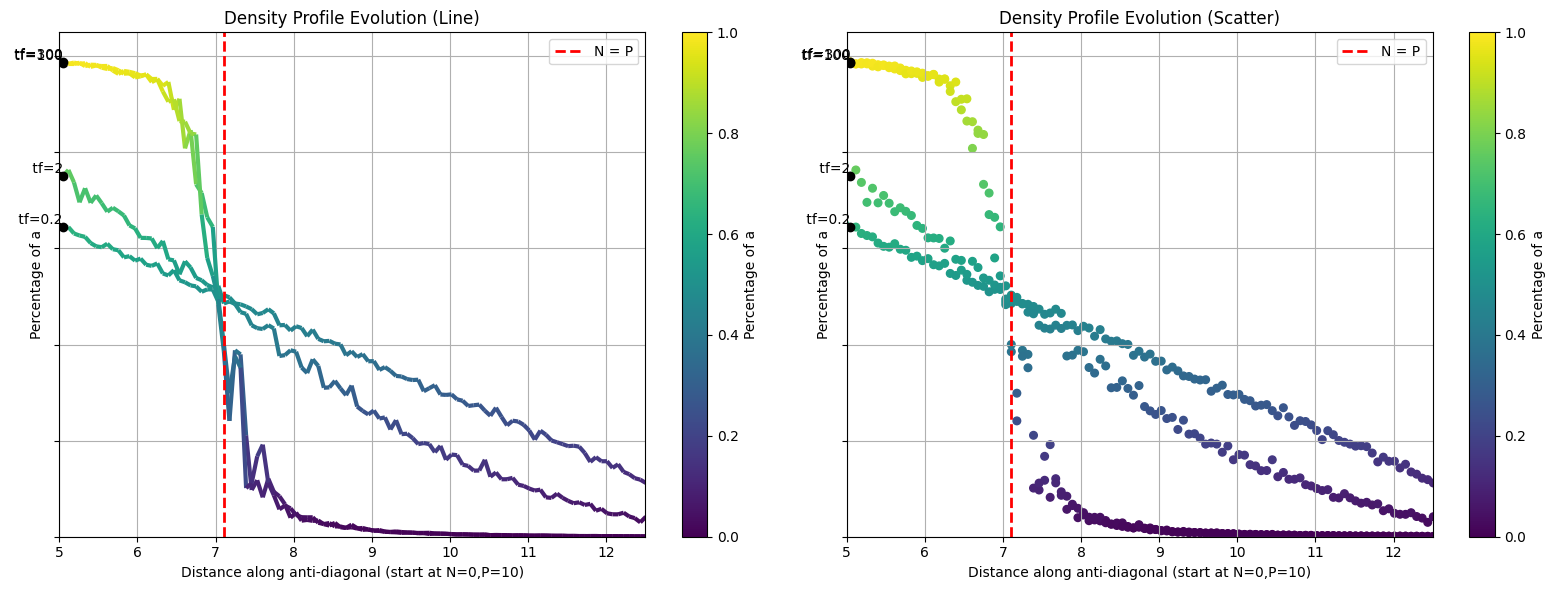

We can see that early stopping freeze most of neurons in a undecided state. The biggest is the noise, the more probable is to find false positive of the classification nearby the frontier, ie, errors.

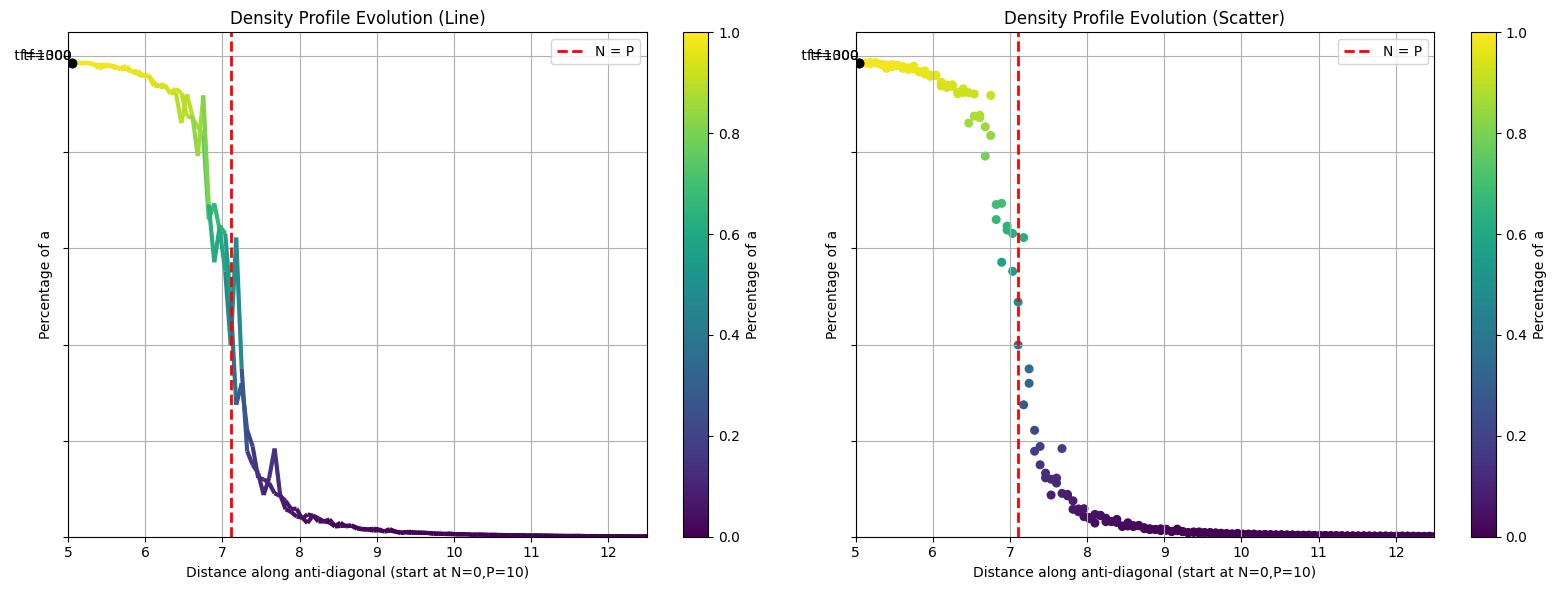

# montrer que temps au voisinage bifurcation diverge, lineariser puis voir (strogatz)
# quantifier faux positifs et négatifs
# avoir des résultats analhytiques
# regarder mail David nb de solutions sans les calculer µ
# conf thermo stochastique jeudi matin 
# programme dans dropbox


There is no significative difference between tf=300 and tf =1000.


### 1.1.3 Convergence time

**ATTENTION** Pour rester dans le régime de bistabilité, une condition nécessaire (mais pas suffisante) est que $$P,N<1.25$$

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# --- Noise and grid setup ---
noise_sigma = 0.2
nb_of_points_grid = 40
P_values = np.linspace(0, 1.25, nb_of_points_grid)
N_values = np.linspace(0, 1.25, nb_of_points_grid)
all_points = [(P, N) for P in P_values for N in N_values]

# --- Time span for single tf ---
tf_single     = 1000
t_eval_single = np.linspace(0, tf_single, 500)

Integrating percentage of a(t): 100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


Percentage of neurons with final a‐percentage within ±5.0% of 50%: 0.38%


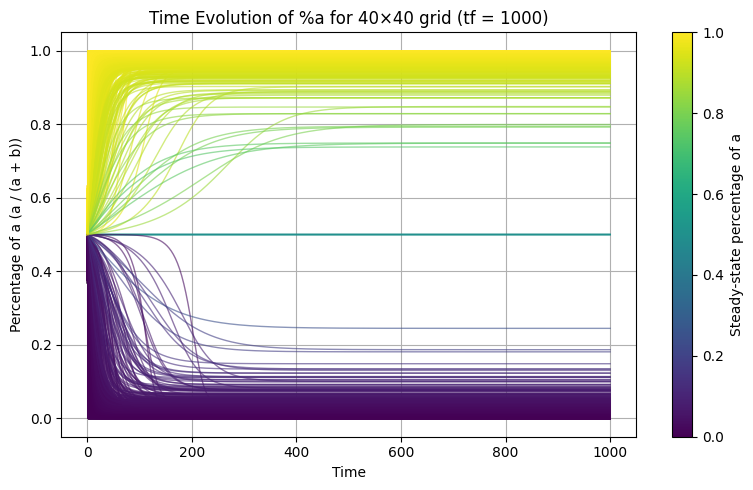

In [8]:
# --- ODE system ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Integration helper ---
def integrate_system(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 500)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45',
                    rtol=1e-8, atol=1e-10)
    return sol.t, sol.y[0], sol.y[1]  # times, a(t), b(t)



# --- Colormap for percentage of a ---
cmap_y = plt.cm.viridis
norm_y = plt.Normalize(vmin=0.0, vmax=1.0)

# --- Tolerance around 50% for counting neurons ---
tol = 0.05  # i.e. count those with |pct_a - 0.5| < 0.05

# --- Plotting setup ---
fig, ax = plt.subplots(figsize=(8, 5))

# we'll collect final percentages to compute the counter
final_pcts = []

for P0, N0 in tqdm(all_points, desc="Integrating percentage of a(t)"):
    # add Gaussian noise to inputs
    noisy_P = max(0, P0 + np.random.normal(scale=noise_sigma))
    noisy_N = max(0, N0 + np.random.normal(scale=noise_sigma))
    
    # integrate up to tf_single
    t, a_t, b_t = integrate_system(noisy_P, noisy_N, 
                                   y0=[1e-6, 1e-6], 
                                   t_span=(0, tf_single),
                                   t_eval=t_eval_single)
    # compute percentage of a
    pct_a = a_t / (a_t + b_t + 1e-10)
    
    # store final percentage
    final_pcts.append(pct_a[-1])
    
    # pick color by final percentage
    color = cmap_y(norm_y(pct_a[-1]))
    
    # plot percentage vs time
    ax.plot(t, pct_a, color=color, lw=1, alpha=0.6)

# compute how many are approximately at 50%
final_pcts = np.array(final_pcts)
mask_50 = np.abs(final_pcts - 0.5) < tol
percent_50 = mask_50.sum() / mask_50.size * 100

# display the result
print(f"Percentage of neurons with final a‐percentage within ±{tol*100:.1f}% of 50%: {percent_50:.2f}%")

# labels and colorbar
ax.set_xlabel("Time")
ax.set_ylabel("Percentage of a (a / (a + b))")
ax.set_title(f"Time Evolution of %a for {nb_of_points_grid}×{nb_of_points_grid} grid (tf = {tf_single})")
ax.grid(True)

sm = plt.cm.ScalarMappable(cmap=cmap_y, norm=norm_y)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Steady‐state percentage of a")

plt.tight_layout()
plt.show()



There is a nice classification, most of neuron ending in the decided state a of b. Nevertheless, there remains some undecided (less than 1%) neuron (50/50 green curves) whose state is 50/50, because either the initial condition was P=N, either we where out of stability, then a=b was a stable fixed point instead of a unstable one.

*This might be an issue*, because so as to ensure bistability, one must add hard constrains on P and N values.
Futhermore, this system takes significantly more time to converge toward a "full decided state" than for the first Rondelez system. 

**Remark** : For the fully symmetric neuron, if one is not considering $P,N<1.25$, then instead of having bistability (full a and full b are stable and a=b is unstable) one has a monostability, in which a=b can be a stable fixed point (see graph below), hence the classification is catastriphic.

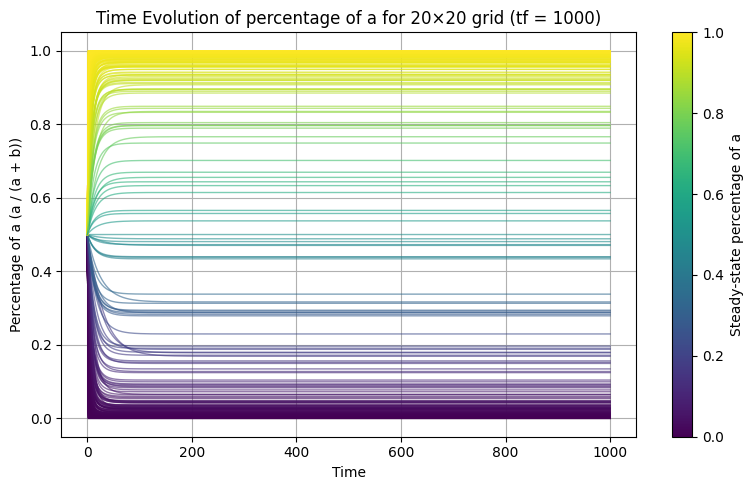

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# --- System parameters ---
eta_a, eta_b       = 0.1, 0.1
mu_a,  mu_b        = 0.2, 0.2
k_a,   k_b         = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

# --- Noise parameters ---
noise_sigma = 0.2  # standard deviation of Gaussian noise on inputs

# --- Integration parameters ---
tf_single      = 1000
t_eval_single  = np.linspace(0, tf_single, 500)

# --- Grid of neurons (P, N values) ---
nb_of_points_grid = 20
P_values          = np.linspace(0, 1.25, nb_of_points_grid)
N_values          = np.linspace(0, 1.25, nb_of_points_grid)
all_neurons       = [(P, N) for P in P_values for N in N_values]

# --- Convergence criterion parameters ---
tol_rate = 1e-3   # threshold on |dp/dt|
M        = 50     # number of consecutive points below threshold





In [58]:
# --- ODE system ---
def da_dt(a, b, P):
    return P + (lambda_a * a)/(1 + k_a*a) - eta_a*a - mu_a*a*b

def db_dt(a, b, N):
    return N + (lambda_b * b)/(1 + k_b*b) - eta_b*b - mu_b*a*b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Convergence time storage ---
convergence_times = []

print(f"Computing convergence times for grid with {nb_of_points_grid**2} neurons...")
for P0, N0 in tqdm(all_neurons, desc="Integrating neurons"):
    # Add Gaussian white noise and clip to non-negative
    noisy_P = max(P0 + np.random.normal(scale=noise_sigma), 0)
    noisy_N = max(N0 + np.random.normal(scale=noise_sigma), 0)

    # Integrate the system
    sol = solve_ivp(system, (0, tf_single), [1e-6, 1e-6],
                    args=(noisy_P, noisy_N),
                    t_eval=t_eval_single,
                    method="RK45", rtol=1e-8, atol=1e-10)

    a_vals, b_vals = sol.y
    pct_a_vals = a_vals / (a_vals + b_vals + 1e-10)  # percentage of a
    t_vals     = sol.t

    # approximate dp/dt by finite differences
    dt   = t_vals[1] - t_vals[0]
    dpdt = np.diff(pct_a_vals) / dt

    # find first time where |dp/dt| < tol_rate for M consecutive points
    conv_time = tf_single
    for i in range(len(dpdt) - M):
        if np.all(np.abs(dpdt[i:i+M]) < tol_rate):
            conv_time = t_vals[i]
            break

    convergence_times.append(conv_time)

convergence_times = np.array(convergence_times)

# --- Compute percentage of neurons converged over time ---
time_grid = np.linspace(0, tf_single, 500)
percentage_converged = [
    100 * np.sum(convergence_times <= t) / convergence_times.size
    for t in time_grid
]




Computing convergence times for grid with 400 neurons...


Integrating neurons: 100%|██████████| 400/400 [00:24<00:00, 16.21it/s]


In [59]:
# --- Plotting range (user-defined) ---
plot_t_min = 0     # e.g. 0
plot_t_max = 1000    # e.g. 50 (must be <= tf_single)

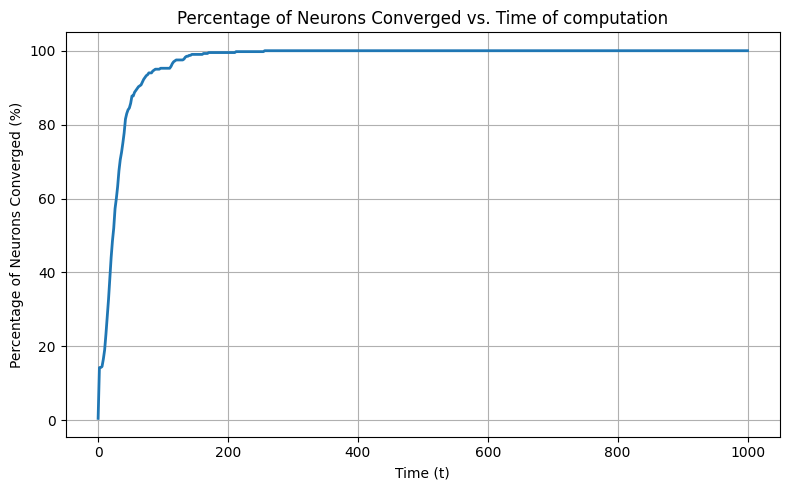

In [61]:
# --- Plot ---
# Mask time and percentage arrays based on plotting range
mask = (time_grid >= plot_t_min) & (time_grid <= plot_t_max)
time_to_plot = time_grid[mask]
percentage_to_plot = np.array(percentage_converged)[mask]


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_to_plot, percentage_to_plot, lw=2)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Percentage of Neurons Converged (%)")
ax.set_title(f"Percentage of Neurons Converged vs. Time of computation")
ax.grid(True)
plt.tight_layout()
plt.show()


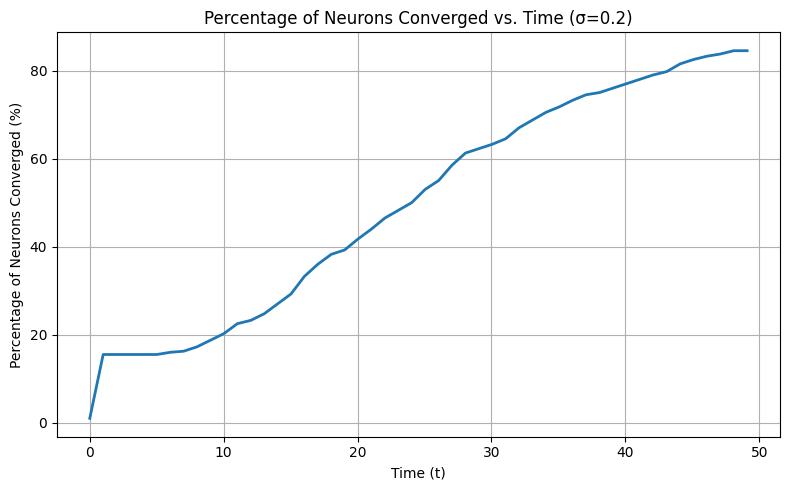

**Q : Why do we have a plateau at $\approx 15%$ ?** 
The WTA decollement initial des 2 courbes est rapide à se mettre en place. En conséquence, les neurones qui avaient des concentration initiales P et N très différents mettent très peu de temps à converger. Peut etre que le second plateau correspond au temps typique de convergence des neurones, la majorité étant dans un état ni trop pres ni trop loin des bassins d'attractions. Pour les autres, ceux qui prennent du temps, c'est une histoire d'être méga loin des bassins d'attraction, ie mega près de P=N... à investiguer

## 1.2 Asymmetrical system


$$
\frac{da}{dt} = P + \frac{\lambda_a \cdot a}{1 + k_a \cdot a} - \eta_a \cdot a - \mu_a \cdot a b
$$
$$
\frac{db}{dt} = N + \frac{\lambda_b \cdot b}{1 + k_b \cdot b} - \eta_b \cdot b - \mu_b \cdot a b
$$


### 1.2.1 Considering $\mu_a=\mu_b$ and $\eta_a=\eta_b$

In this section, we want to probe the effect of introducing asymmetry between $\alpha, \eta,\mu$ parameters for a and b, leading to a non N=P frontier.

First, as assumed in our computations, we take $\mu_a=\mu_b$ and $\eta_a=\eta_b$.

- We can define the Michaelis constant $K_a=1/k_a$, which mean the higher $k_a$ is, the lower $K_a$ is, hence, the faster the process reaches full speed saturation.

- $\alpha_a$ holds for the autocathalytic rate

If we want to introduce asymmetry, we can start by probing the effect of $k_a$ and $\alpha_a$


***(a) numerical solving***

-- Explication de la résolution numérique--


Numeriquement, on cherche à tracer la frontière où $a^* = b^*$, c'est-à-dire le point d'équilibre où les deux populations, $a$ et $b$, se stabilisent à des niveaux égaux (équilibre dynamique)

2. Utilisation de l'Option Numérique pour Trouver la Frontière


Plutôt que d'utiliser une *formule analytique directe* pour $P = f(N)$, on résout le problème de manière *numérique* en suivant ces étapes :

-Étape 1 : Définition du Problème d'Équilibre



Nous cherchons à trouver la *frontière* $a^* = b^*$. Pour chaque valeur de $N$, nous cherchons $P$ tel que $a = b$ à l'état stationnaire.

-Étape 2 : L'Équation pour $a^* = b^*$


Pour chaque valeur de $N$ dans l'intervalle $[0, N_{\text{max}}]$, le code cherche un *point d'équilibre* où $a = b$. Cela se fait en résolvant une équation du type :

$$
a^*(P, N) = b^*(P, N)
$$

Ainsi, nous cherchons $a^*$ tel que $\dot{a} = \dot{b} = 0$. Le code résout cette condition avec l'*équation* construite sur la dynamique du système, en utilisant la fonction `steady_diff`.

La fonction `steady_diff(P, N)` calcule la différence entre $a$ et $b$ obtenus après avoir résolu le système d'équations différentielles :


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from tqdm.notebook import tqdm
from itertools import product

# --- 1. Paramètres du modèle ---
eta_a, eta_b = 0.1, 0.1
mu_a,  mu_b  = 0.2, 0.2
k_a,   k_b   = 0.7,  0.3
lambda_a, lambda_b = 1.0, 1.0

# --- 2. Domaine d'étude ---
N_max, P_max = 2.0, 2.0

# grille pour integration + bruit
nb_of_points = 50
P_grid = np.linspace(0, P_max, nb_of_points)
N_grid = np.linspace(0, N_max, nb_of_points)
noise_sigma = 0.2

# conditions initiales et temps
y0      = [1e-6, 1e-6]
t_span  = (0, 100)

  0%|          | 0/2500 [00:00<?, ?it/s]

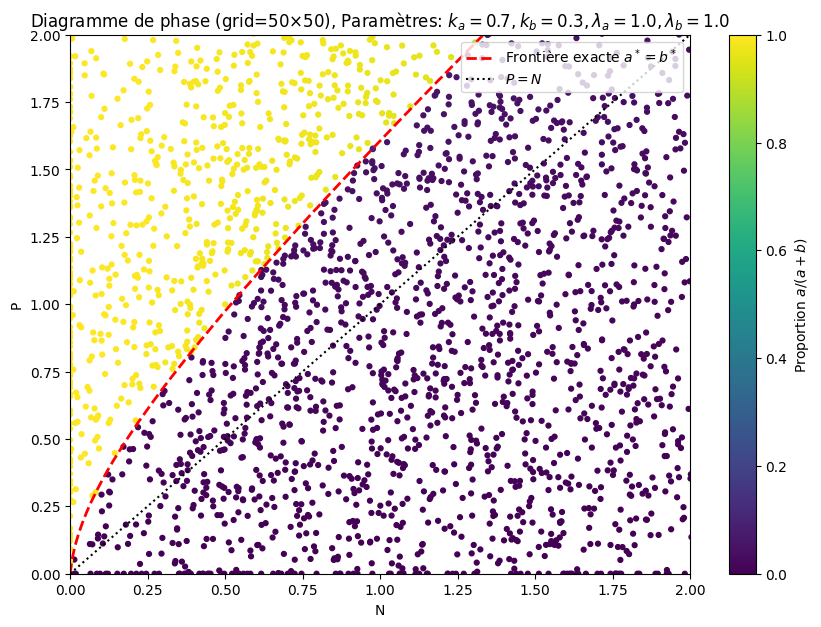

In [16]:
# --- 3. Définitions du système ODE ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

def integrate_ode(P, N):
    """Renvoie (a*, b*) à la fin de l'intégration."""
    sol = solve_ivp(system, t_span, y0, args=(P, N),
                    dense_output=False, method='RK45',
                    rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]

# --- 4. Génération des données de simulation ---
results = []
for P0, N0 in tqdm(product(P_grid, N_grid),
                   total=nb_of_points**2):
    Pn = max(0, P0 + np.random.normal(scale=noise_sigma))
    Nn = max(0, N0 + np.random.normal(scale=noise_sigma))
    a_fin, b_fin = integrate_ode(Pn, Nn)
    results.append((Pn, Nn,
                    np.clip(a_fin, 0, 10),
                    np.clip(b_fin, 0, 10)))

results    = np.array(results)
P_plot     = results[:,0]
N_plot     = results[:,1]
a_low      = results[:,2]
b_low      = results[:,3]
a_fraction = a_low / (a_low + b_low + 1e-12)

# --- 5. Tracé du diagramme de phase ---
fig, ax = plt.subplots(figsize=(10,7))
sc = ax.scatter(N_plot, P_plot, c=a_fraction,
                cmap='viridis', s=12, marker='o')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Proportion $a/(a+b)$")

ax.set_xlabel("N")
ax.set_ylabel("P")
ax.set_title(
    f"Diagramme de phase (grid={nb_of_points}×{nb_of_points}), "
    f"Paramètres: $k_a={k_a},k_b={k_b},\\lambda_a={lambda_a},\\lambda_b={lambda_b}$"
)

# --- 6. Calcul et tracé de la frontière a* = b* par option 2 ---
frontier_N = []
frontier_P = []

# Balayage des N pour trouver P tel que a*(P,N) = b*(P,N)
def steady_diff(P, N):
    a_s, b_s = integrate_ode(P, N)
    return a_s - b_s

N_vals = np.linspace(0, N_max, 300)
for N in N_vals:
    try:
        sol = root_scalar(steady_diff, args=(N,),
                          bracket=[0, P_max], method='brentq', xtol=1e-3)
        if sol.converged:
            frontier_N.append(N)
            frontier_P.append(sol.root)
    except ValueError:
        # pas de racine dans [0,P_max]
        pass

ax.plot(frontier_N, frontier_P,
        linestyle='--', color='red', lw=2,
        label="Frontière exacte $a^*=b^*$")

# --- Ligne diagonale P = N ---
diag_max = min(P_max, N_max)
ax.plot([0, diag_max], [0, diag_max],
        linestyle=':', color='black', lw=1.5,
        label="$P=N$")

ax.set_xlim(0, N_max)
ax.set_ylim(0, P_max)
ax.legend()



**(b) semi-analytical solving**

As one want the fixed point equation for $(a^*,b^*)$ then $\dot{x}=0$. So as to recover the frontier, the previous equation must satisfy $a^*=b^*$. This yelds to the frontier equation i.e. {$(P,N)/a^*=b^*$ according to the fp equation}
$$P=N+(\frac{\lambda_b}{1+k_b a^*}-\frac{\lambda_a}{1+k_a a^*})a^*$$


  0%|          | 0/900 [00:00<?, ?it/s]

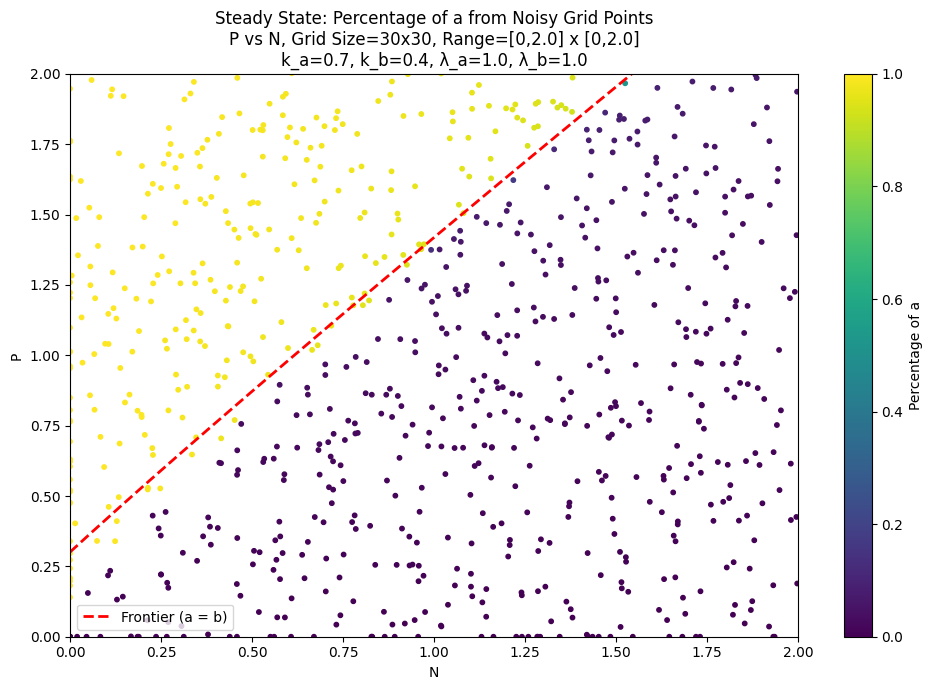

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from tqdm.notebook import tqdm
from itertools import product

# --- Parameters ---
eta_a = 0.1
eta_b = 0.1
mu_a = 0.2
mu_b = 0.2

k_a = 0.7
k_b = 0.4
lambda_a = 1.0
lambda_b = 1.0

# --- Display range ---
N_max = 2.0
P_max = 2.0

# --- Parameter grid for numerical integration ---
nb_of_points = 30
P_grid = np.linspace(0.0, P_max, nb_of_points)
N_grid = np.linspace(0.0, N_max, nb_of_points)

# Noise parameters
noise_sigma = 0.2

# Time span and initial condition
t_span_full = (0, 100)
y0 = [1e-6, 1e-6]

# --- System equations ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Integration ---
def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]

# --- Generate simulation data ---
results = []
for P, N in tqdm(product(P_grid, N_grid), total=nb_of_points * nb_of_points):
    noisy_P = max(0.0, P + np.random.normal(loc=0, scale=noise_sigma))
    noisy_N = max(0.0, N + np.random.normal(loc=0, scale=noise_sigma))

    a_final, b_final = integrate_ode(noisy_P, noisy_N, y0, t_span_full)
    results.append((noisy_P, noisy_N, np.clip(a_final, 0, 10), np.clip(b_final, 0, 10)))

results = np.array(results)
P_plot = results[:, 0]
N_plot = results[:, 1]
a_low_plot = results[:, 2]
b_low_plot = results[:, 3]

# --- Plot phase diagram ---
fig, ax = plt.subplots(figsize=(10, 7))

a_percentage = a_low_plot / (a_low_plot + b_low_plot + 1e-10)

title = (
    f"Steady State: Percentage of a from Noisy Grid Points\n"
    f"P vs N, Grid Size={nb_of_points}x{nb_of_points}, Range=[0,{P_max}] x [0,{N_max}]\n"
    f"k_a={k_a}, k_b={k_b}, λ_a={lambda_a}, λ_b={lambda_b}"
)

sc = ax.scatter(N_plot, P_plot, c=a_percentage, cmap='viridis', s=10, marker='o')
ax.set_title(title)
ax.set_xlabel("N")
ax.set_ylabel("P")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Percentage of a")

# --- Compute and plot frontier a = b numerically ---
frontier_N = []
frontier_P = []

N_vals = np.linspace(0.0, N_max, 500)

for N in N_vals:
    def fixed_point_eq(a):
        return N + (lambda_b * a) / (1 + k_b * a) - eta_b * a - mu_b * a**2

    try:
        sol = root_scalar(fixed_point_eq, bracket=(1e-8, 20.0), method='brentq')
        if sol.converged:
            a_star = sol.root
            P = - (lambda_a * a_star) / (1 + k_a * a_star) + eta_a * a_star + mu_a * a_star**2
            if 0 <= P <= P_max:
                frontier_N.append(N)
                frontier_P.append(P)
    except ValueError:
        continue  # no solution in bracket

ax.plot(frontier_N, frontier_P, color='red', linestyle='--', linewidth=2, label='Frontier (a = b)')

# Final plot setup
ax.set_xlim(0, N_max)
ax.set_ylim(0, P_max)
ax.legend()
plt.tight_layout()
plt.show()


FIND A FRONTIER EQUATION WHICH IS A FUNCVTION OF ka lambdaa AND SEE HOW IT BEHAVES AS WE MODIFY THOSE VALUES

### 1.2.3 Convergence time



# Pour le neurone symmetrique on devait considérer $P,N<1.25$ pour assurer la stability. Voir si on peut s'en passer avec d'autres valeurs des parametres